# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

In [1]:
from unityagents import UnityEnvironment
import numpy as np

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher.app')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
# env.close()

Now, let's train our own Agent

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
from agent import Agent

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

In [11]:
def ddpg(n_episodes=1000, max_t=10000):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_deque.append(score)       # save most recent score
        scores.append(score)             # save most recent score

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [12]:
scores = ddpg(n_episodes = 500)


Episode 1	Score: 0.76	Average Score: 0.76
Episode 1	Average Score: 0.76
Episode 2	Score: 0.37	Average Score: 0.56
Episode 2	Average Score: 0.56
Episode 3	Score: 0.35	Average Score: 0.49
Episode 3	Average Score: 0.49
Episode 4	Score: 0.47	Average Score: 0.49
Episode 4	Average Score: 0.49
Episode 5	Score: 0.76	Average Score: 0.54
Episode 5	Average Score: 0.54
Episode 6	Score: 0.53	Average Score: 0.54
Episode 6	Average Score: 0.54
Episode 7	Score: 0.67	Average Score: 0.56
Episode 7	Average Score: 0.56
Episode 8	Score: 0.89	Average Score: 0.60
Episode 8	Average Score: 0.60
Episode 9	Score: 0.95	Average Score: 0.64
Episode 9	Average Score: 0.64
Episode 10	Score: 0.17	Average Score: 0.59
Episode 10	Average Score: 0.59
Episode 11	Score: 0.58	Average Score: 0.59
Episode 11	Average Score: 0.59
Episode 12	Score: 0.35	Average Score: 0.57
Episode 12	Average Score: 0.57
Episode 13	Score: 1.27	Average Score: 0.62
Episode 13	Average Score: 0.62
Episode 14	Score: 0.34	Average Score: 0.60
Episode 14	Av

Episode 112	Score: 5.90	Average Score: 4.41
Episode 112	Average Score: 4.41
Episode 113	Score: 7.83	Average Score: 4.47
Episode 113	Average Score: 4.47
Episode 114	Score: 7.49	Average Score: 4.54
Episode 114	Average Score: 4.54
Episode 115	Score: 9.61	Average Score: 4.63
Episode 115	Average Score: 4.63
Episode 116	Score: 7.63	Average Score: 4.70
Episode 116	Average Score: 4.70
Episode 117	Score: 8.79	Average Score: 4.77
Episode 117	Average Score: 4.77
Episode 118	Score: 11.15	Average Score: 4.87
Episode 118	Average Score: 4.87
Episode 119	Score: 9.61	Average Score: 4.93
Episode 119	Average Score: 4.93
Episode 120	Score: 9.79	Average Score: 5.01
Episode 120	Average Score: 5.01
Episode 121	Score: 9.17	Average Score: 5.10
Episode 121	Average Score: 5.10
Episode 122	Score: 11.91	Average Score: 5.22
Episode 122	Average Score: 5.22
Episode 123	Score: 3.50	Average Score: 5.25
Episode 123	Average Score: 5.25
Episode 124	Score: 8.05	Average Score: 5.32
Episode 124	Average Score: 5.32
Episode 12

Episode 218	Score: 39.63	Average Score: 19.89
Episode 218	Average Score: 19.89
Episode 219	Score: 39.30	Average Score: 20.18
Episode 219	Average Score: 20.18
Episode 220	Score: 34.66	Average Score: 20.43
Episode 220	Average Score: 20.43
Episode 221	Score: 39.60	Average Score: 20.74
Episode 221	Average Score: 20.74
Episode 222	Score: 36.35	Average Score: 20.98
Episode 222	Average Score: 20.98
Episode 223	Score: 23.32	Average Score: 21.18
Episode 223	Average Score: 21.18
Episode 224	Score: 38.56	Average Score: 21.48
Episode 224	Average Score: 21.48
Episode 225	Score: 34.59	Average Score: 21.72
Episode 225	Average Score: 21.72
Episode 226	Score: 35.18	Average Score: 21.92
Episode 226	Average Score: 21.92
Episode 227	Score: 26.19	Average Score: 22.11
Episode 227	Average Score: 22.11
Episode 228	Score: 14.33	Average Score: 22.04
Episode 228	Average Score: 22.04
Episode 229	Score: 34.13	Average Score: 22.28
Episode 229	Average Score: 22.28
Episode 230	Score: 12.91	Average Score: 22.32
Episod

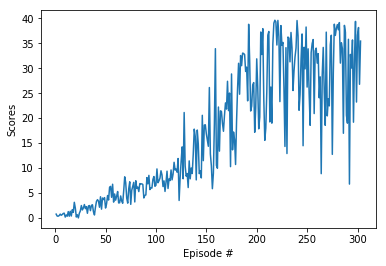

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()